In [ ]:
git add .

git remote add origin git@github.com:Philipp-Blankenhagen:DL-from-scratch

In [2]:
import torch, torchvision
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


# MLP

In [81]:
# Getting the dataset
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False)

X = trainset.data
y = trainset.targets
X = X.type(torch.float)
X = (X/255)

X_test = testset.data
y_test = testset.targets
X_test = X_test.type(torch.float)
X_test = (X_test/255)


# Preprocessing/Transforming
# Define a series of transformations
transform = transforms.Compose([
    #transforms.RandomRotation(20),
    transforms.Lambda(lambda x: x.view(x.size(0), -1)) # Flatten the tensor
])

X_t = transform(X)
y_t = y


X_test = transform(X_test)
X_test_gpu = X_test.to(device)
y_test_gpu = y_test.to(device)


X_gpu = X_t.to(device)
y_gpu = y.to(device)
# Convert to Dataset and put in a DataLoader
tensor_dataset = TensorDataset(X_gpu, y_gpu)
dataloader = DataLoader(tensor_dataset,batch_size=100,shuffle = True)


tensor_dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(tensor_dataset_test,batch_size=100)


In [82]:
class model_linear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Linear(784, 5000,bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(5000, 10000,bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(10000, 10000,bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(10000, 5000,bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(5000, 5000,bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(5000, 5000,bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(5000,10,bias=True),
            torch.nn.Softmax(dim =1)
        )

    def forward(self,X):
        y_pred = self.main(X)
        return y_pred
    
    def predict(self,X):
        with torch.no_grad():
            y_pred = self.main(X)
            y_class = torch.argmax(y_pred,dim=1)
        return y_class

In [83]:


# Instantiate your model and transfer it to GPU (if available)
model = model_linear().to(device)


In [84]:

opt = torch.optim.Adadelta(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

train_acc_list = []
test_acc_list = []

for epoch in range(5):
    for batch, (X,y) in enumerate(dataloader):
        #print(f'Batch {batch}, Loss {loss}')
        opt.zero_grad()
        y_pred = model.forward(X)
        loss = criterion(y_pred,y)
        loss.backward()
        opt.step()
        
    
        if ((batch%50) == 0) or True:
            acc_batch_train = sum((torch.argmax(y_pred,dim=1)-y) == 0)/len(y)
            y_test_pred = model.forward(X_test_gpu[:1000])

            acc_test = sum((torch.argmax(y_test_pred,dim=1)-y_test_gpu[:1000]) == 0)/1000

            print('Batch:',batch,' Training Accuracy:', acc_batch_train.item())
            print('Testing Accuracy:',acc_test.item())
            train_acc_list.append(acc_batch_train.item())
            test_acc_list.append(acc_test.item())
    
    print(f'\n\nEpoch {epoch} \n\n')
    
    

Batch: 0  Training Accuracy: 0.07999999821186066
Testing Accuracy: 0.11599999666213989
Batch: 1  Training Accuracy: 0.15000000596046448
Testing Accuracy: 0.11599999666213989


KeyboardInterrupt: 

# CNN

In [7]:
# Getting the dataset
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False)

X = trainset.data
y = trainset.targets
X = X.type(torch.float)
X = (X/255)

X_test = testset.data
y_test = testset.targets
X_test = X_test.type(torch.float)
X_test = (X_test/255)


# Preprocessing/Transforming
# Define a series of transformations
transform = transforms.Compose([
    #transforms.RandomRotation(20),
    #transforms.Lambda(lambda x: x.view(x.size(0), -1)) # Flatten the tensor
])

X_t = transform(X)
y_t = y


X_test = transform(X_test)
X_test_gpu = X_test.to(device)
y_test_gpu = y_test.to(device)


X_gpu = X_t.to(device)
y_gpu = y.to(device)
# Convert to Dataset and put in a DataLoader
tensor_dataset = TensorDataset(X_gpu, y_gpu)
dataloader = DataLoader(tensor_dataset,batch_size=100,shuffle = True)


tensor_dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(tensor_dataset_test,batch_size=100)


In [9]:
# Convolutional Neural Network

class Conv_Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1,out_channels = 6,kernel_size = (3,3),stride = 1,padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
            torch.nn.Conv2d(in_channels = 6,out_channels = 16,kernel_size = (5,5),stride = 1,padding = 0),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size = 2,stride = 2),
            torch.nn.Flatten(start_dim = 1),
            torch.nn.Linear(49*16,120),
            torch.nn.ReLU(),
            torch.nn.Linear(120,84),
            torch.nn.ReLU(),
            torch.nn.Linear(84,10),
            torch.nn.Softmax(dim = 1)
        )


    def forward(self,X):
        y_pred = self.main(X)
        return y_pred

In [439]:
(model.forward(dataloader.dataset.tensors[0][0]))

tensor([0.1761, 0.0026, 0.4907, 0.1703, 0.0032, 0.0173, 0.0153, 0.0007, 0.1165,
        0.0074], grad_fn=<SoftmaxBackward0>)

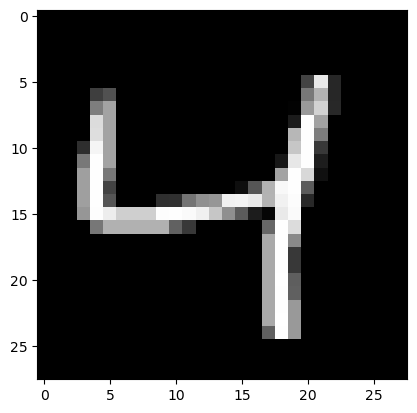

In [32]:
%matplotlib inline
img = dataloader.dataset.tensors[0][2].view(28,28)
plt.imshow(img, cmap='gray')  # Use the 'gray' colormap for grayscale images
plt.show()